# 1D vertical electric sounding (VES)

In this tutorial, we use the GeoPVI package to perform a simple **vertical electrical sounding (VES)** experiment. This problem has entirely different (non-seismological) physics compared to other examples provided in GeoPVI.

VES is used to estimate **1D layered subsurface electrical resistivity structure** using measurements of **voltage from an electrical field** induced by distant grounded electrodes. The method is primarily employed for exploration of subsurface water resources, and can be useful in many environmental and engineering areas. 

In VES, apparent resistivity measurements are obtained by deploying an array of current electrodes or potential electrodes into the ground, at a set of probe spacings. This creates an electrical field which allows potential differences to be measured, and electrical resistivity to be calculated. By varying the electrode spacings, the observations are sensitive to subsurface resistivity at different depths. 

The forward problem that prodicts synthetic resistivity model as a function of depth is solved using the **pyGIMLi** package ([https://www.pygimli.org/documentation.html](https://www.pygimli.org/documentation.html)). Therefore, to run this tutorial you need to first install the **pyGIMLi** package ([https://github.com/gimli-org/gimli](https://github.com/gimli-org/gimli)).

## Import libraries

In [1]:
import numpy as np
import torch
import geopvi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygimli as pg
from pygimli.physics.ves import VESRhoModelling, VESManager

In [2]:
torch.set_default_dtype(torch.float64)

## Define true model and noisy data

In [3]:
synres = np.array([100., 500., 30., 800.])  # synthetic resistivity
synthk = np.array([0.5, 3.5, 6.])  # synthetic thickness (nlay-th layer is infinite)

In [4]:
ab2 = np.logspace(-0.5, 1.5, 8)  # AB/2 distance (current electrodes)

In [5]:
synthModel = np.hstack([synthk, synres])  # concatenate thickness and resistivity
ves = VESManager()
rhoa, err = ves.simulate(synthModel, ab2=ab2, mn2=ab2/3, noiseLevel=0.03, seed = 0)

In [6]:
rhoa

8 [109.0570179595148, 120.19407958306174, 170.05146939919138, 257.3885548886415, 320.57898770119317, 266.2842963784602, 161.9985967320118, 127.37346201690723]

### Display true resistivity model and observed data

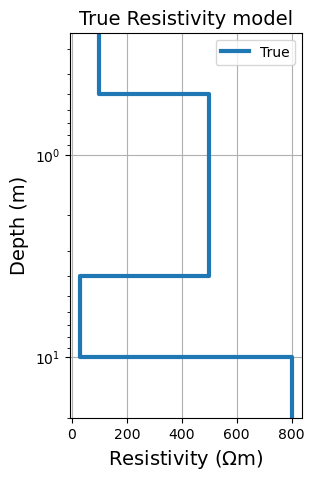

In [7]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 5))  # two-column figure
ves.showModel(synthModel, ax=ax, label="True", plot="semilogy", zmax=20, linewidth = 3)
ax.legend()
ax.set_yticks([1, 10])
ax.set_ylabel('Depth (m)', fontsize = 14)
ax.set_xlabel('Resistivity ($\Omega$m)', fontsize = 14)
ax.set_title('True Resistivity model', fontsize = 14)

plt.show()

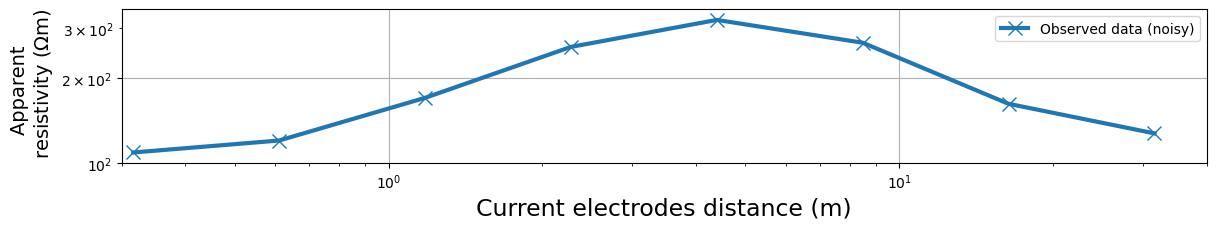

In [8]:
fig, ax = plt.subplots(figsize = (14, 2))

ax.plot(ab2, np.array(rhoa), label = 'Observed data (noisy)', marker = 'x',  markersize= 10, linewidth = 3)
ax.set_xlabel('Current electrodes distance (m)', fontsize = 17)
ax.set_ylabel('Apparent \n resistivity ($\Omega$m)', fontsize = 14)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xticks([0.5, 1, 10])
ax.set_xlim([0.3, 40])
ax.legend()
ax.set_ylim([100, 350])
ax.set_yticks([100, 200])
ax.grid()

plt.show()

## Perform inversion using the [pyGIMLi](https://www.pygimli.org/documentation.html) package

In [9]:
nlay = 4
ves.invert(rhoa, err, ab2=ab2, mn2=ab2/3, nLayers=nlay, lam=1000, lambdaFactor=0.8)

07/10/24 - 13:02:40 - pyGIMLi - INFO - Created startmodel from forward operator: 7, min/max=0.052705/166.025033


7 [0.057372877821467105, 0.45014876162451134, 1.493190383850912, 177.24254040825903, 94.1415908472909, 774.8281995994306, 117.01381578415955]

## Perform Bayesian inversion using GeoPVI

### Define a Uniform prior distribution for resistivity value and layer thickness for each layer.

note that the last layer is assumed to be a half space thus its thickness doesn't need to be calculated.

In [10]:
from geopvi.prior import Uniform

In [11]:
lower = np.array([0.01, 1, 3, 50, 100, 1, 500])
upper = np.array([1., 5, 10, 200, 1000, 200, 2000])

In [12]:
prior = Uniform(lower = lower, upper = upper)

### Define function to calculate log posterior probability values

In [13]:
def forward_sw(x, relative_step = 0.01, requires_grad = True, sigma = 0.03):
    d_syn, err = ves.simulate(x, ab2=ab2, mn2=ab2/3, noiseLevel=sigma, seed = 0)

    gradient = np.zeros((len(ab2), len(x)))
    if requires_grad:
        for i in range(len(x)):
            x_tmp = x.copy()
            step = relative_step * x[i]
            x_tmp[i] += step
            
            d_tmp, err = ves.simulate(x_tmp, ab2=ab2, mn2=ab2/3, noiseLevel=sigma, seed = 0)            
            derivative = (d_tmp - d_syn) / abs(step)
            gradient[:, i] = derivative
    return np.array(d_syn), gradient

In [14]:
data, grad = forward_sw(synthModel, relative_step = 0.001)

In [15]:
from torch.multiprocessing import Pool
from torch.autograd import Function

In [16]:
class ForwardModel(Function):
    @staticmethod
    def forward(ctx, input, func):
        output, grad = func(input)
        ctx.save_for_backward(input, torch.tensor(grad))
        return torch.tensor(output)

    @staticmethod
    def backward(ctx, grad_output):
        input, grad = ctx.saved_tensors
        grad_input = (grad_output[...,None] * grad).sum(axis = -2)
        return grad_input, None

In [17]:
class Posterior():
    def __init__(self, data, sigma = 0.03, log_prior = None):
        self.log_prior = log_prior
        self.data = data
        self.sigma = sigma

    def solver(self, x):
        '''
        Calculate modelled data and data-model gradient by calling the external forward function (pyGIMLi)
        '''
        m, n = x.shape
        rho = np.zeros([m, self.data.shape[0]])
        gradient = np.zeros([m, self.data.shape[0], n])
        for i in range(m):
            vs = x.data.numpy()[i].squeeze()
            rho[i], gradient[i] = forward_sw(vs, relative_step = 0.0001, requires_grad = True, sigma = 0.03)
        return rho, gradient
        
    def log_prob(self, x):
        """
        calculate log posterior and its gradient directly from model x
        This version considers the transform from real to constrained space
        thus returns log_loke + log_det
        """
        d_syn = ForwardModel.apply(x, self.solver)
        log_like = - 0.5 * torch.sum(((torch.from_numpy(self.data) - d_syn)/self.sigma) ** 2, axis = -1)
        log_prior = self.log_prior(x)

        logp = log_like + log_prior
        return logp

In [18]:
d_obs = np.array(rhoa)
posterior = Posterior(d_obs, sigma = 2, log_prior = prior.log_prob)

## Define variational model

### Normalising flows

In [19]:
from geopvi.nfvi.flows import NSF_CL, Permute, Real2Constr, RealNVP, SIAF, NSF_SAR

In [20]:
flows_nf = []

for _ in range(4):
    flows_nf += [SIAF(dim = synthModel.size, hidden_dim = [6, 6]), Permute(dim = synthModel.size)]
flows_nf += [Real2Constr(dim = synthModel.size, lower = lower, upper = upper)]

In [21]:
from geopvi.nfvi.models import FlowsBasedDistribution

variational_nf = FlowsBasedDistribution(flows_nf, base = 'Normal')

In [22]:
from geopvi.nfvi.models import VariationalInversion

nf = VariationalInversion(variationalDistribution = variational_nf, log_posterior = posterior.log_prob)
loss_nf = nf.update(optimizer = 'torch.optim.Adam', lr = 0.001, n_iter = 10000, nsample = 5, n_out = 5, verbose = True)

----------------------------------------

Iteration:     0,	Loss:    6245.59
The elapsed time is: 0.05 s
Iteration:  2000,	Loss:      26.95
The elapsed time is: 81.43 s
Iteration:  4000,	Loss:      21.62
The elapsed time is: 162.82 s
Iteration:  6000,	Loss:      20.77
The elapsed time is: 244.18 s
Iteration:  8000,	Loss:      20.74
The elapsed time is: 325.63 s
Iteration: 10000,	Loss:      21.61
The elapsed time is: 407.05 s
----------------------------------------

Finish training!


In [23]:
samples_nf = variational_nf.sample(5000)

## Display inversion results

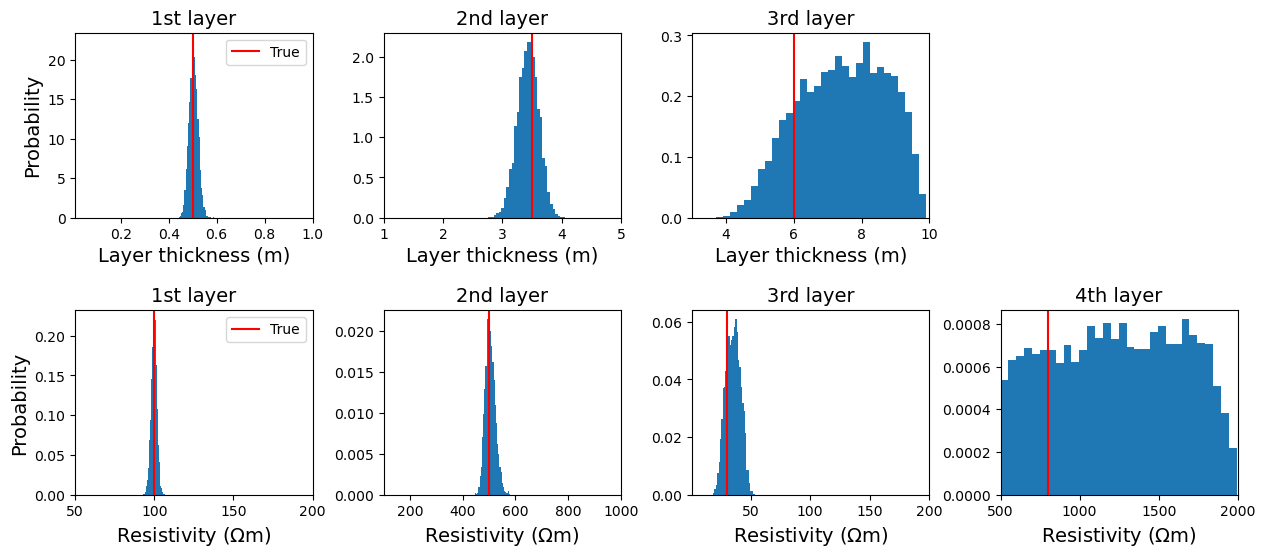

In [24]:
title = ['1st layer', '2nd layer', '3rd layer', '4th layer']

fig = plt.figure(figsize = (15, 6))

for i in range(3):
    plt.subplot(2, 4, i+1)
    plt.hist(samples_nf[:,i], density=True, bins = 30)
    
    plt.xlim(lower[i], upper[i])
    plt.axvline(x = synthModel[i], color = 'red', label = 'True')
    plt.xlabel('Layer thickness (m)', fontsize = 14)
    if i == 0:
        plt.legend()
        plt.ylabel('Probability', fontsize = 14)
    plt.title(title[i], fontsize = 14)
    
for i in range(4):
    plt.subplot(2, 4,i+1+4)
    plt.hist(samples_nf[:,i+3], density=True, bins = 30)    
    if i == 0:
        plt.xlim([50, 200])
    else:
        plt.xlim(lower[i+3], upper[i+3])
    plt.axvline(x = synthModel[i+3], color = 'red', label = 'True')
    plt.xlabel('Resistivity ($\Omega$m)', fontsize = 14)
    if i == 0:
        plt.legend()
        plt.ylabel('Probability', fontsize = 14)
    plt.title(title[i], fontsize = 14)
    
fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

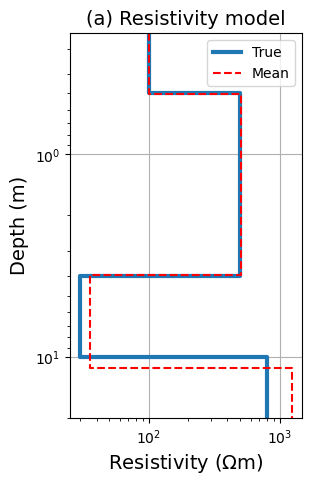

In [25]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 5))  # two-column figure
ves.showModel(synthModel, ax=ax, label="True", plot="semilogy", zmax=20, linewidth = 3)
ves.showModel(samples_nf.mean(axis = 0), ax=ax, label="Mean", zmax=20, linestyle = '--', color = 'red')
ax.legend()
ax.set_yticks([1, 10])
ax.set_ylabel('Depth (m)', fontsize = 14)
ax.set_xlabel('Resistivity ($\Omega$m)', fontsize = 14)
ax.set_title('(a) Resistivity model', fontsize = 14)

plt.show()

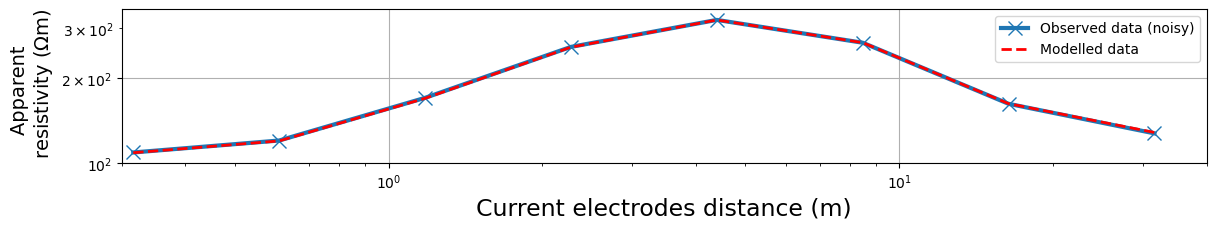

In [26]:
fig, ax = plt.subplots(figsize = (14, 2))

ax.plot(ab2, np.array(rhoa), label = 'Observed data (noisy)', marker = 'x',  markersize= 10, linewidth = 3)
ax.plot(ab2, ves.simulate(samples_nf.mean(axis = 0), ab2=ab2, mn2=ab2/3, noiseLevel=0.03, seed = 0)[0], label = 'Modelled data', 
                            linewidth = 2, linestyle = '--', color = 'red')
ax.set_xlabel('Current electrodes distance (m)', fontsize = 17)
ax.set_ylabel('Apparent \n resistivity ($\Omega$m)', fontsize = 14)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xticks([0.5, 1, 10])
ax.set_xlim([0.3, 40])
ax.legend()
ax.set_ylim([100, 350])
ax.set_yticks([100, 200])
ax.grid()

plt.show()